In [1]:
%pylab inline
import pymc3 as pm
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## The model:

$p(y, x_n) = \text{Normal}(y \mid 0, 3) \times \displaystyle\prod_{n=1}^{9} \text{Normal}(x_n \mid 0, \text{exp}(y / 2))$

In [2]:
nd = 9

In [3]:
# compute log density
nres = 500
xval = np.linspace(-20, 20, nres)
yval = np.linspace(-9, 9, nres)
xv, yv = np.meshgrid(xval, yval)

# formally it need marginalization if nd > 1
logp_2d = st.norm.logpdf(yv, loc=0., scale=3.) +\
    st.norm.logpdf(xv, loc=0., scale=np.exp(yv/2))

In [4]:
# forward random
nsample = 10000
yr = st.norm.rvs(loc=0., scale=3., size=nsample)
xnr = st.norm.rvs(loc=0., scale=np.exp(yr/2), size=(nd, nsample))

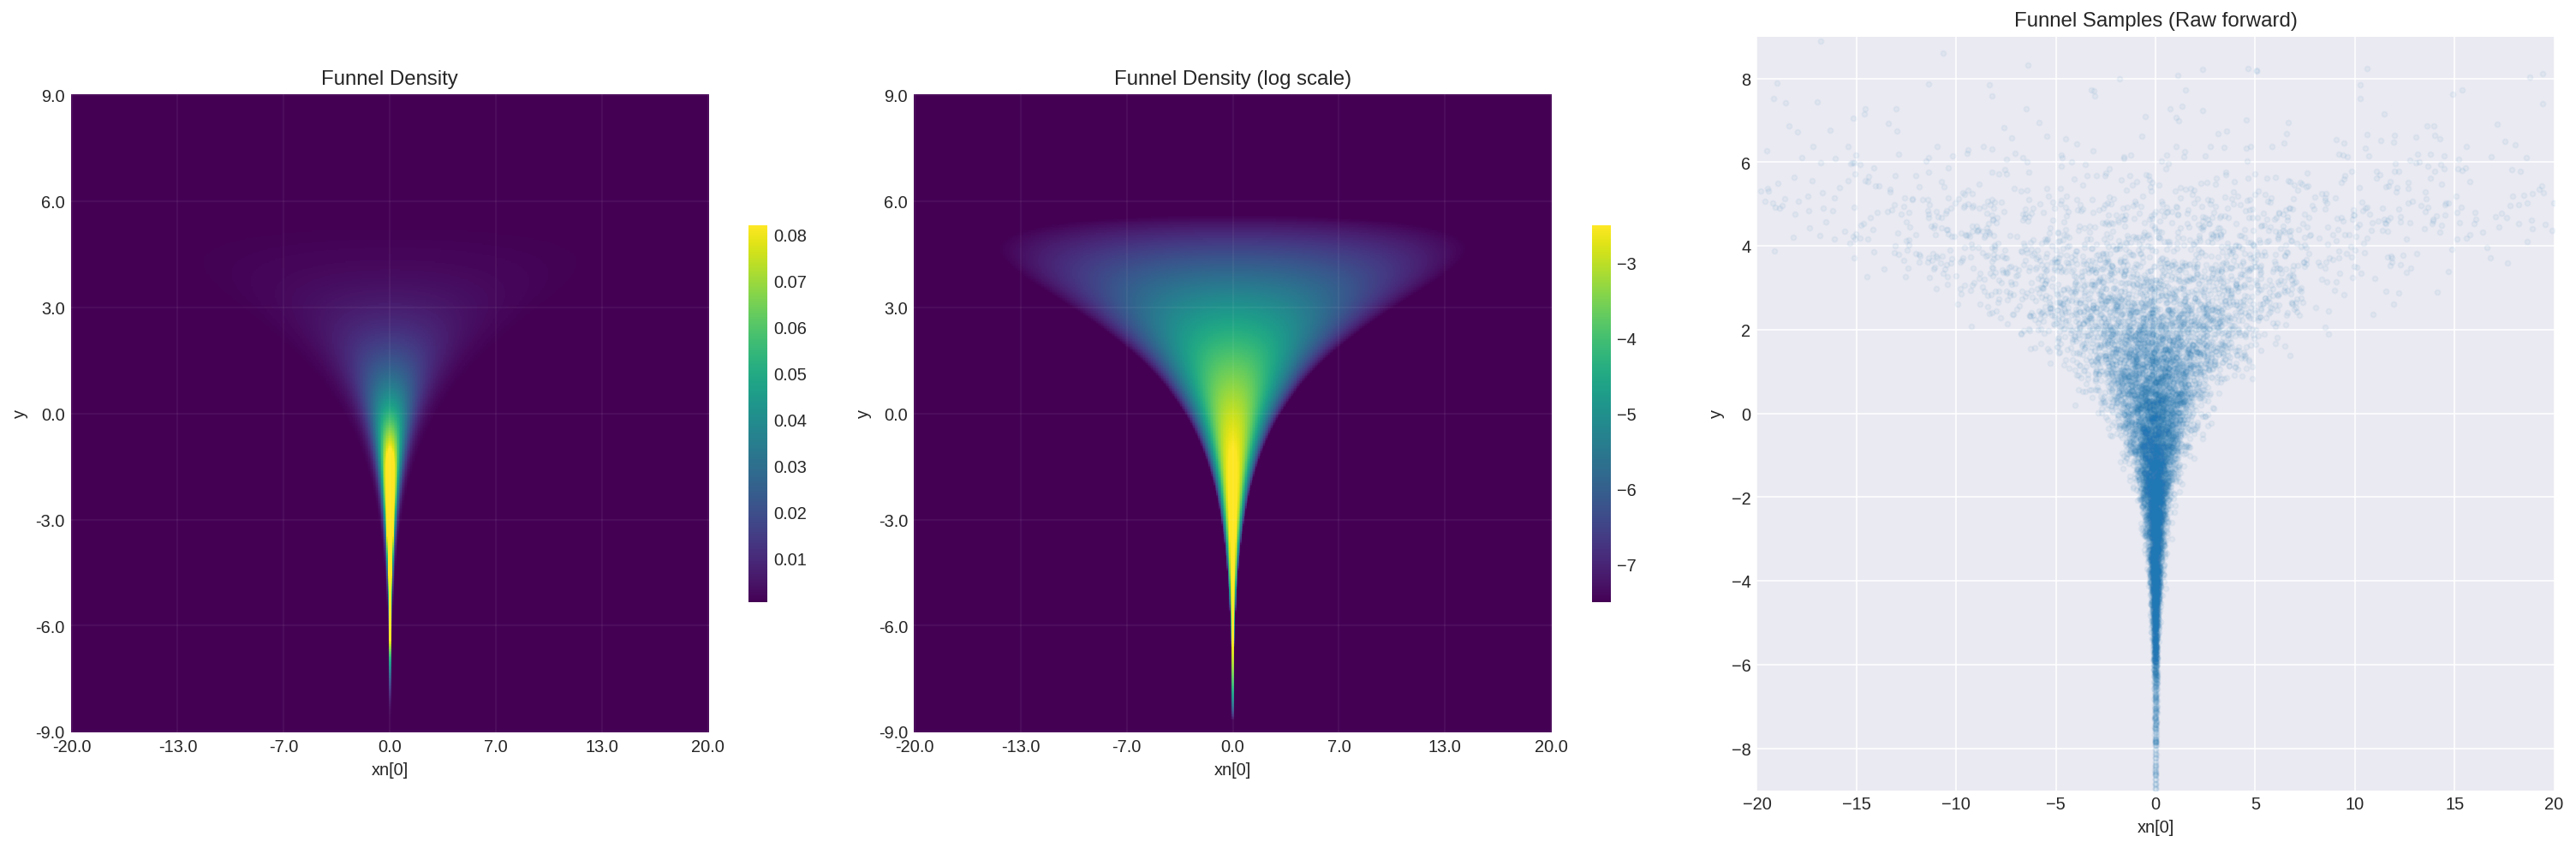

In [5]:
def show_logp2d(logp_2d, ax, func = lambda x: x):
    img = ax.imshow(func(logp_2d), 
                     vmin=func(-7.5), vmax=func(-2.5), 
                     cmap='viridis', origin='lower')
    ax.grid(color='w', linestyle='-', linewidth=1, alpha=.05)
    ax.set_yticks(np.linspace(0, 499, 7))
    ax.set_yticklabels(np.linspace(-9, 9, 7).round())
    ax.set_xticks(np.linspace(0, 499, 7))
    ax.set_xticklabels(np.linspace(-20, 20, 7).round())
    ax.set_xlabel('xn[{}]'.format(ib))
    ax.set_ylabel('y')
    plt.colorbar(img, ax=ax, shrink=.5)
    return ax

def show_sample2d(xnr, yr, ib, ax):
    ax.scatter(xnr[ib], yr, marker='.', alpha=.05)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-9, 9)
    ax.set_xlabel('xn[{}]'.format(ib))
    ax.set_ylabel('y')
    return ax

ib = 0
_, ax = plt.subplots(1, 3, figsize=(21, 7))
show_logp2d(logp_2d, ax[0], np.exp)
ax[0].set_title('Funnel Density')
show_logp2d(logp_2d, ax[1])
ax[1].set_title('Funnel Density (log scale)')
show_sample2d(xnr, yr, ib, ax[2])
ax[2].set_title('Funnel Samples (Raw forward)')
plt.tight_layout();

In [6]:
with pm.Model() as m_raw:
    y_ = pm.Normal('y', mu=0., sd=3.)
    x_ = pm.Normal('x', mu=0., sd=pm.math.exp(y_/2), shape=nd)
    trace = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, y]
100%|██████████| 3000/3000 [00:05<00:00, 593.52it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '1924' (I am process '1925')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '1924' (I am process '1926')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '1925' (I am process '1926')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
Th

In [7]:
divg = trace.get_sampler_stats('diverging')

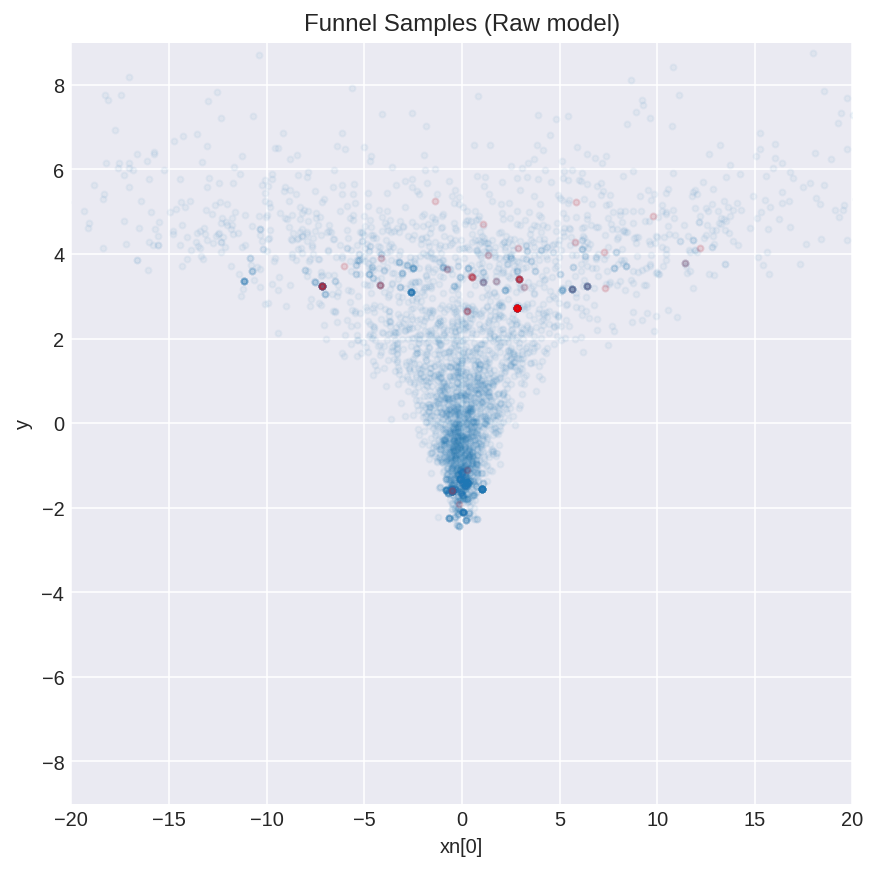

In [8]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace['x'].T, trace['y'], ib, ax)
ax.scatter(trace['x'][divg, ib], trace['y'][divg], marker='.', color='r', alpha=.1)
ax.set_title('Funnel Samples (Raw model)');

In [9]:
with pm.Model() as m_tran:
    y_raw = pm.Normal('y_raw', mu=0., sd=1.)
    x_raw = pm.Normal('x_raw', mu=0., sd=1., shape=nd)
    y_ = pm.Deterministic('y', 3. * y_raw)
    x_ = pm.Deterministic('x', pm.math.exp(y_/2) * x_raw)
    trace2 = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_raw, y_raw]
100%|██████████| 3000/3000 [00:03<00:00, 914.03it/s]


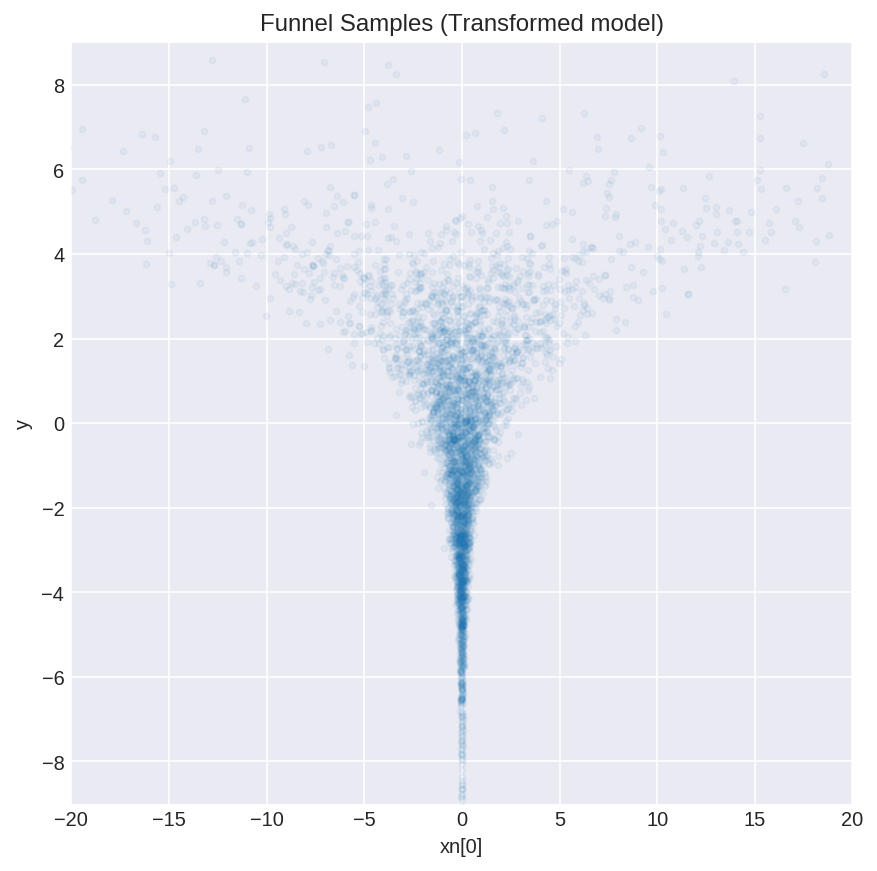

In [10]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace2['x'].T, trace2['y'], ib, ax)
ax.set_title('Funnel Samples (Transformed model)');

In [11]:
yr2 = st.norm.rvs(loc=0., scale=1., size=nsample) * 3.
xnr2 = st.norm.rvs(loc=0., scale=1., size=(nd, nsample)) * np.exp(yr2/2)

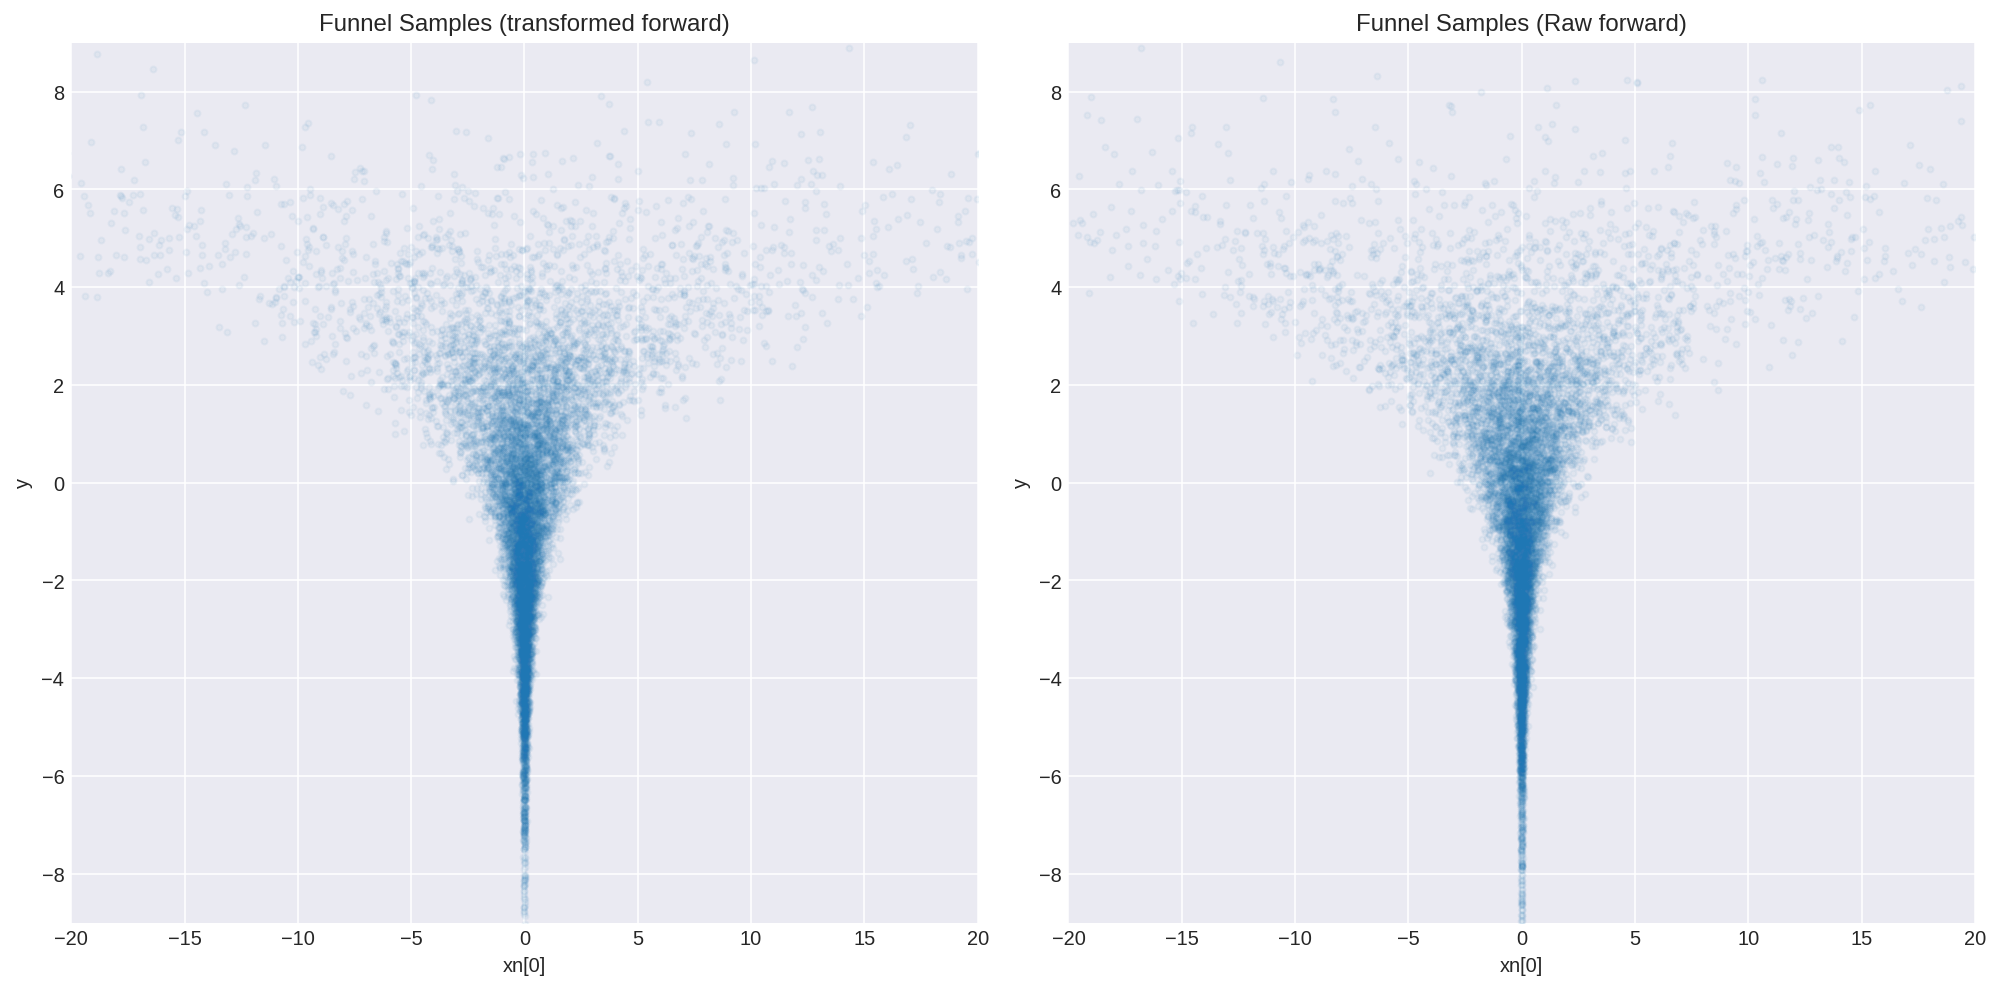

In [12]:
_, ax = plt.subplots(1, 2, figsize=(14, 7))
show_sample2d(xnr2, yr2, ib, ax[0])
ax[0].set_title('Funnel Samples (transformed forward)')
show_sample2d(xnr, yr, ib, ax[1])
ax[1].set_title('Funnel Samples (Raw forward)')
plt.tight_layout();

# Measure-preserving transformation

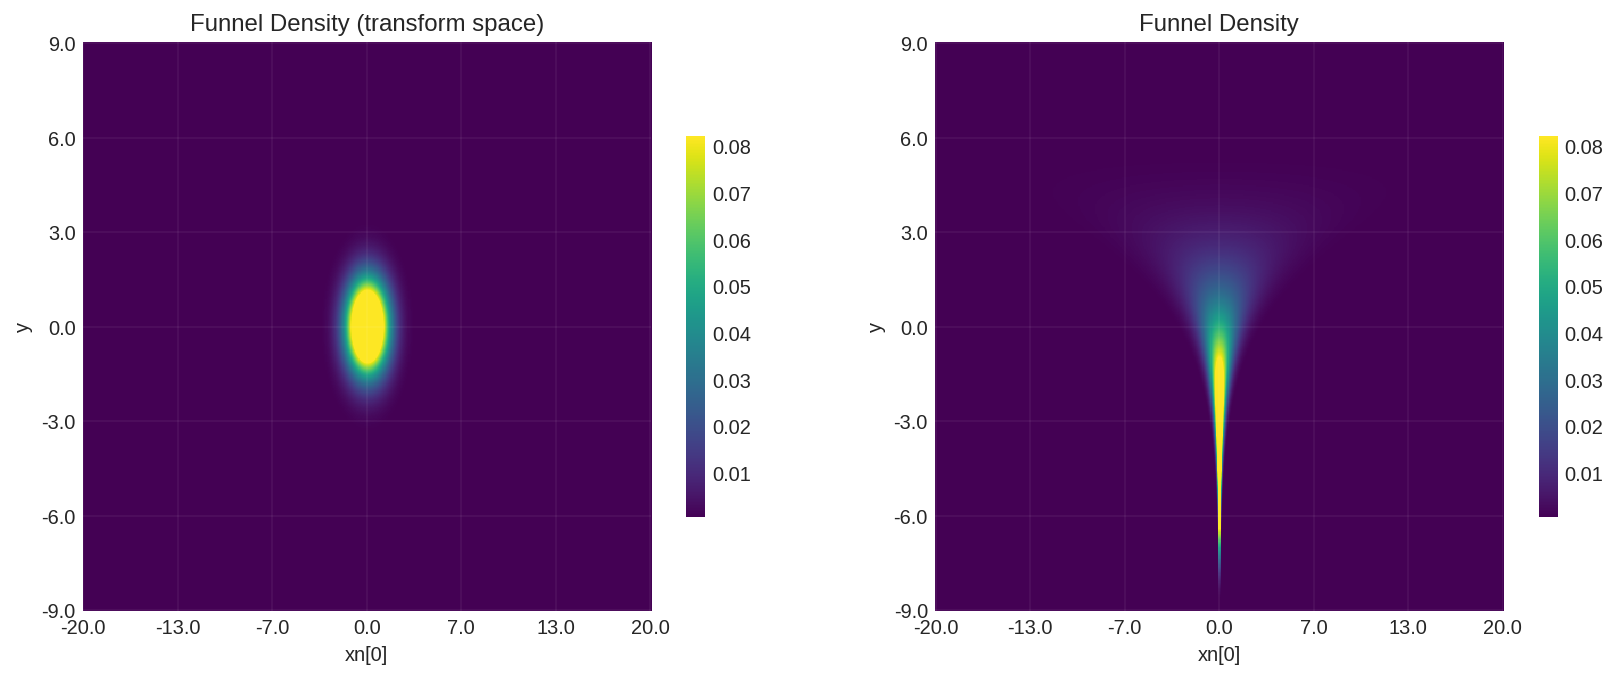

In [13]:
_, ax = plt.subplots(1, 2, figsize=(14, 7))
logp_2d_t = st.norm.logpdf(yv, loc=0., scale=1.) +\
    st.norm.logpdf(xv, loc=0., scale=1.)
show_logp2d(logp_2d_t, ax[0], np.exp)
ax[0].set_title('Funnel Density (transform space)')
show_logp2d(logp_2d, ax[1], np.exp)
ax[1].set_title('Funnel Density');

# nres2 = 50
# xval2 = np.linspace(-20, 20, nres2)
# yval2 = np.linspace(-9, 9, nres2)
# xv2, yv2 = np.meshgrid(xval2, yval2)
# V = yv2 * 3.
# U = xv2 * np.exp(V/2.)
# M = st.norm.logpdf(yv2, loc=0., scale=1.) +\
#     st.norm.logpdf(xv2, loc=0., scale=1.)
# Q = ax[2].quiver(xv2, yv2, U, V, M, units='x',  width=0.05,
#                scale=1/.25, cmap='viridis');

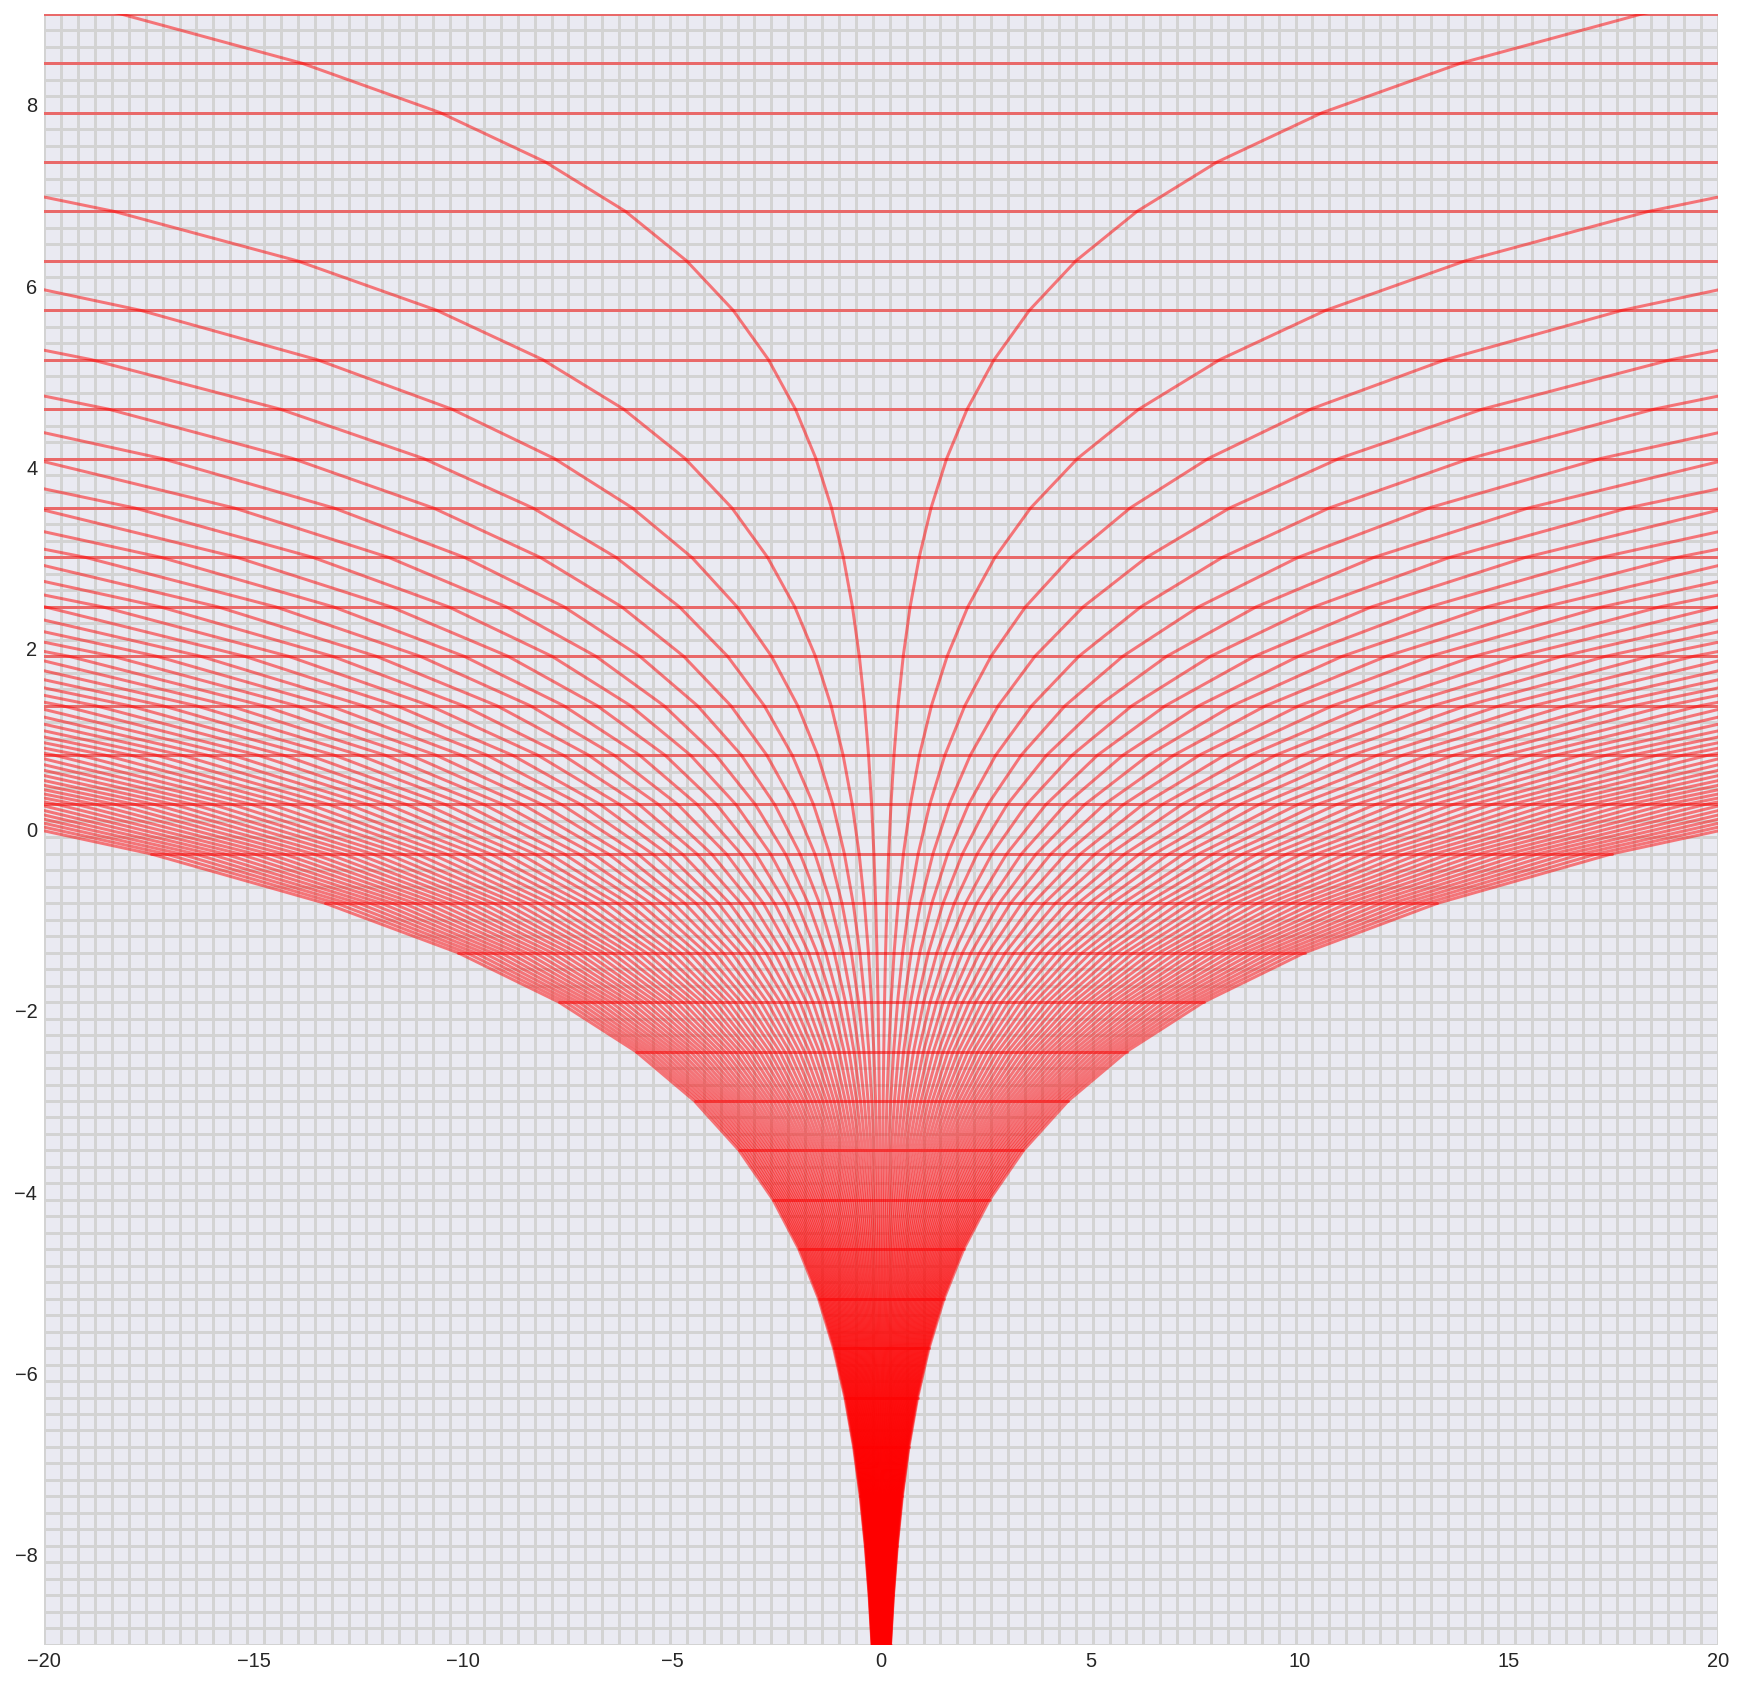

In [14]:
def plot_grid(ax, gridx, gridy, **kwargs):
    for i in range(gridx.shape[0]):
        ax.plot(gridx[i, :], gridy[i, :], **kwargs)
    for i in range(gridx.shape[1]):
        ax.plot(gridx[:, i], gridy[:, i], **kwargs)
    ax.grid('off')


def f(x, y): return (np.exp(y*3/2.) * x, y*3.)


_, ax = plt.subplots(1, 1, figsize=(15, 15))

nres2 = 100
xval2 = np.linspace(-20, 20, nres2)
yval2 = np.linspace(-9, 9, nres2)
xv2, yv2 = np.meshgrid(xval2, yval2)
plot_grid(ax, xv2, yv2, color="lightgrey")

distx, disty = f(xv2, yv2)
plot_grid(ax, distx, disty, color="r", alpha=.5)

ax.set_xlim(-20, 20)
ax.set_ylim(-9, 9);

In [17]:
pt = m_raw.test_point
pt

{'x': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'y': array(0.)}

In [22]:
# you can varify that the logp is not really the same
logp_ref = lambda x, y: st.norm.logpdf(y, loc=0., scale=3.) +\
    st.norm.logpdf(x, loc=0., scale=np.exp(y/2)).sum()
print('The sum(logp) of the test point is {}'.format(logp_ref(pt['x'], pt['y'])))
print('Compute sum(logp) using the model: {}'.format(m_raw.logp(pt)))

The sum(logp) of the test point is -10.287997620714837
Compute sum(logp) using the model: -10.287997620714835


In [23]:
m_tran.test_point

{'x_raw': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'y_raw': array(0.)}

In [61]:
def forward_point(point):
    pt = point
    pt['y'] = point['y_raw']*3.
    pt['x'] = point['x_raw']*np.exp(pt['y']/2)
    return pt

def inverse_point(point):
    pt = point
    pt['y_raw'] = point['y']/3.
    pt['x_raw'] = point['x']/np.exp(point['y']/2)
    return pt

In [62]:
print('Compute sum(logp) using the transformed model: {}'.format(m_tran.logp(inverse_point(pt))))

Compute sum(logp) using the transformed model: -9.689385332046724


In [63]:
pt['y'] = -3.
print('The sum(logp) of the test point is {}'
      .format(logp_ref(pt['x'], pt['y'])))
print('Compute sum(logp) using the model: {}'
      .format(m_raw.logp(pt)))
print('Compute sum(logp) using the transformed model: {}'
      .format(m_tran.logp(inverse_point(pt))))

The sum(logp) of the test point is 2.712002379285164
Compute sum(logp) using the model: 2.7120023792851637
Compute sum(logp) using the transformed model: -9.689385332046724


In [94]:
with pm.Model() as m_tran_withjac:
    y_raw = pm.Normal('y_raw', mu=0., sd=1.)
    x_raw = pm.Normal('x_raw', mu=0., sd=1., shape=nd)
    y_ = pm.Deterministic('y', 3. * y_raw)
    x_ = pm.Deterministic('x', pm.math.exp(y_/2) * x_raw)
    
    pm.Potential('pot', np.log(1/3)+pm.math.log(pm.math.abs_(pm.math.exp(-y_/2)))*nd)

In [95]:
print('Compute sum(logp) using the transformed model with correct jacobian_det: {}'
      .format(m_tran_withjac.logp(inverse_point(pt))))

Compute sum(logp) using the transformed model with correct jacobian_det: 2.712002379285167


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_raw, y_raw]
100%|██████████| 3000/3000 [00:03<00:00, 874.64it/s]


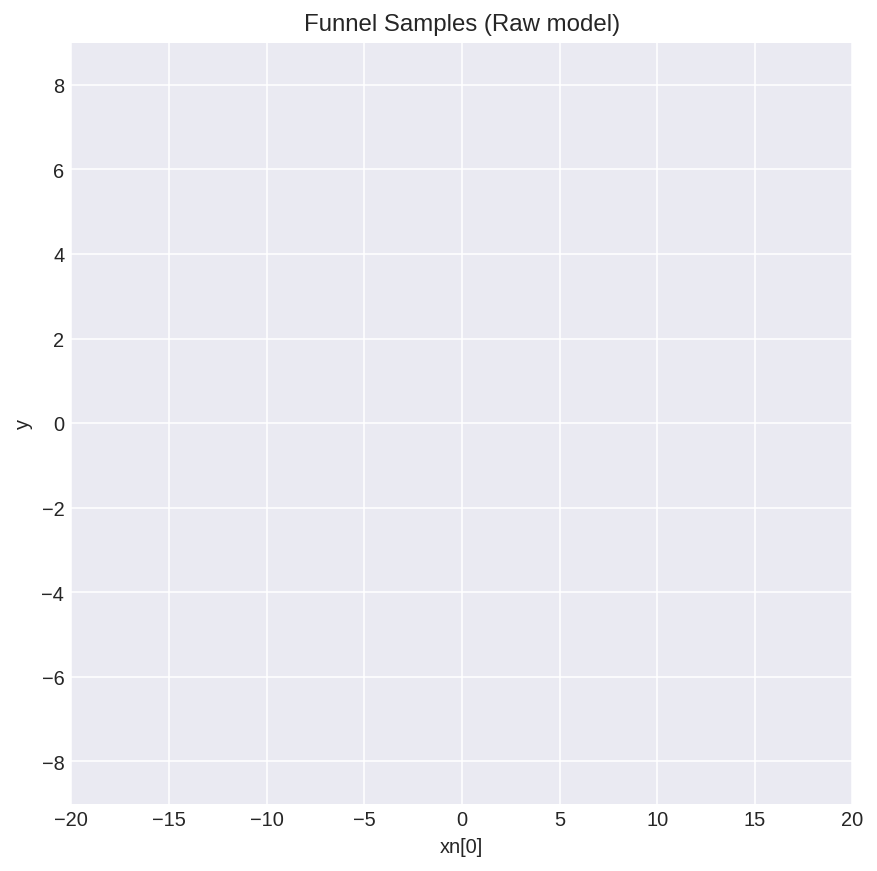

In [96]:
with m_tran_withjac:
    trace3 = pm.sample(1000, tune=2000)

divg = trace3.get_sampler_stats('diverging')

_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace3['x'].T, trace3['y'], ib, ax)
# ax.scatter(trace3['x'][divg, ib], trace3['y'][divg], marker='.', color='r', alpha=.1)
ax.set_title('Funnel Samples (Raw model)');